# Latar Belakang
Produksi konten digital saat ini semakin meningkat seiring dengan berkembangnya teknologi dan akses internet, salah satu platform konten ditigal terbesar saat ini adalah netflix. Netflix adalah sebuah platform layanan streaming yang menyediakan berbagai jenis konten audio-visual seperti film, acara TV, dan dokumenter. Pengguna Netflix dapat menonton konten favorit mereka secara online melalui perangkat yang terhubung ke internet seperti komputer, smart phone, atau smart TV.

Sebuah production house saat ini tertarik untuk merekrut seorang data analis untuk memberikan insight dan rekomendasi mengenai jenis konten yang sedang diminati oleh konsumen. Tugas utama data analis tersebut adalah menganalisis data yang ada untuk mengidentifikasi tren dan preferensi konsumen terkait jenis konten.

***
# Rumusan Masalah
Sebagai bentuk persiapan untuk menghadapi persaingan yang semakin ketat di dunia konten digital, pihak production house ingin mengetahui :
- Jenis konten apa yang sedang diminati oleh konsumen di platform Netflix?
- Genre konten apa yang sedang populer di kalangan pengguna Netflix?
- Kapan waktu premiere yang tepat untuk merilis konten agar dapat menarik minat konsumen?
- Bagaimana tren pertumbuhan short konten dan bagaimana performanya berdasarkan nilai IMDB Score?

***
# Data
Untuk menjawab pertanyaan di atas, kita akan menganalisa data yang sudah dikumpulkan. Namun sebelum itu tahap pertama yang akan kita lakukan adalah memahami data yang sudah diberikan lalu melakukan data cleaning jika diperlukan.

In [197]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from scipy.stats import norm

import re
from scipy.stats import iqr
from unidecode import unidecode

In [198]:
df = pd.read_csv("Netflix Originals.csv", parse_dates= ['Premiere'], index_col= 0)
df.head()

,Title,Genre,Premiere,Runtime,IMDB Score,Language
0,#REALITYHIGH,Comedy,2017-09-08,99,5.2,English
1,13th,Documentary,2016-10-07,100,8.2,English
2,13th: A Conversation with Oprah Winfrey & Ava DuVernay,Aftershow / Interview,2017-01-26,36,7.1,English
3,15 August,Comedy-drama,2019-03-29,124,5.8,Marathi
4,1922,Horror/Crime drama,2017-10-20,102,6.3,English


Dataset ini berisikan informasi dari konten dan rating score IMDB. Dataset memiliki 6 kolom, yaitu:
- Title = judul konten
- Genre = genre konten
- Premiere = waktu premiere
- Runtime = durasi dalam satuan menit
- IMDB Score = IMDB score (per tanggal 06-01-21)
- Language = bahasa yang tersedia (per tanggal 06-01-21)

***
# Data Understanding

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 0 to 583
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Title       584 non-null    object        
 1   Genre       584 non-null    object        
 2   Premiere    584 non-null    datetime64[ns]
 3   Runtime     584 non-null    int64         
 4   IMDB Score  580 non-null    float64       
 5   Language    584 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 31.9+ KB


In [200]:
df.isna().sum()

Title         0
Genre         0
Premiere      0
Runtime       0
IMDB Score    4
Language      0
dtype: int64

Dataset memiliki 584 baris data dengan format yang sudah benar, namun terdapat missing value pada kolom 'IMDB Score'
***

In [201]:
display(df.describe() ,df.describe(include= 'object'))

,Runtime,IMDB Score
count,584.000000,580.000000
mean,93.577055,6.277414
std,27.761683,0.978380
min,4.000000,2.500000
25%,86.000000,5.700000
50%,97.000000,6.400000
75%,108.000000,7.000000
max,209.000000,9.000000


,Title,Genre,Language
count,584,584,584
unique,584,115,38
top,#REALITYHIGH,Documentary,English
freq,1,159,401


- Rata-rata konten memiliki durasi 93 menit
- IMDB score memiliki rentang nilai dari angka 2.5 - 9
- Terdapat 115 macam genre. Hal ini kurang masuk akal jika kita hanya memperhitungkan main genre, di bawah akan kita analisa dengan lebih detail
- Genre dengan konten paling banyak adalah documentary
- Bahasa yang paling banyak digunakan adalah bahasa inggris
***

In [202]:
max_date = df['Premiere'].max()
min_date = df['Premiere'].min()

display(max_date, min_date)

Timestamp('2021-05-27 00:00:00')

Timestamp('2014-12-13 00:00:00')

Konten paling baru di-rilis pada tanggal 27-05-2021, sementara konten paling lama di-rilis pada tanggal 13-12-2014
***

In [203]:
df.corr()

,Runtime,IMDB Score
Runtime,1.000000,-0.039425
IMDB Score,-0.039425,1.000000


Kolom 'IMDB Score' dan 'Runtime' tidak memiliki korelasi
***

In [204]:
df[~df['Title'].map(str.isascii)]

,Title,Genre,Premiere,Runtime,IMDB Score,Language
9,7 años,Drama,2016-10-28,76,6.8,Spanish
106,Como Caído del Cielo,Musical comedy,2019-12-24,112,6.4,Spanish
313,Òlòt?ré,Crime drama,2020-10-02,106,5.5,English
548,Tribhanga  Tedhi Medhi Crazy,Drama,2021-01-15,95,6.1,Hindi


Terdapat judul dengan karakter yang bukan merupakan ASCII karakter
***

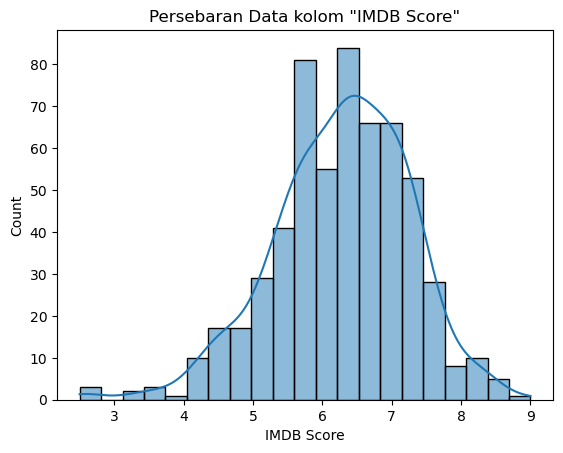

In [205]:
plt.title('Persebaran Data kolom "IMDB Score"')
sns.histplot(data=df['IMDB Score'], kde=True)

plt.show()

Secara visual data pada kolom "IMDB Score' terlihat berpola left skewed, mari kita pastikan dengan box plot

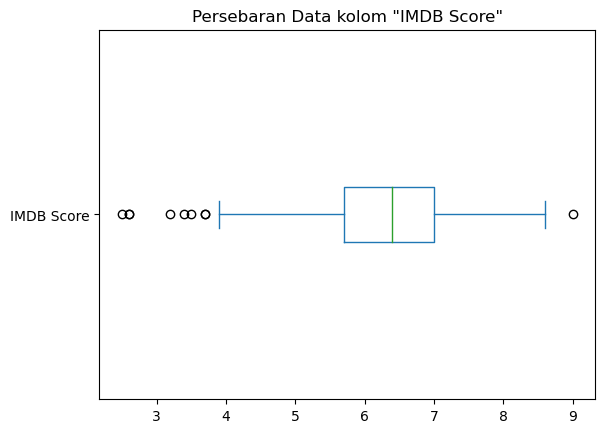

In [206]:
plt.title('Persebaran Data kolom "IMDB Score"')

df['IMDB Score'].plot(kind= 'box', vert= False, title= 'Persebaran Data kolom "IMDB Score"');


Visualisasi dari boxplot jelas menunjukan ada banyak outlier di nilai IMDB yang rendah. Dengan melihat persebaran datanya dengan histogram dan boxplot kita dapat menyimpulkan bahwa<br> kolom 'IMDB Score' memiliki persebaran data yang tidak normal (left skewed).
***

In [207]:
pd.set_option('display.max_colwidth', -1)
# data unik di tiap kolom
listItem = []
for col in df.columns :
    listItem.append([col, df[col].nunique(), df[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
tabel1Desc

C:\Users\msi pc\AppData\Local\Temp\ipykernel_1144\3174120122.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Column Name,Number of Unique,Unique Sample
0,Title,584,"[#REALITYHIGH, 13th, 13th: A Conversation with Oprah Winfrey & Ava DuVernay, 15 August, 1922, 22 July, 5 Star Christmas, 6 Balloons, 6 Underground, 7 años, A 3 Minute Hug, A Babysitter's Guide to Monster Hunting, A California Christmas, A Christmas Prince, A Christmas Prince: The Royal Baby, A Christmas Prince: The Royal Wedding, A Fall from Grace, A Futile and Stupid Gesture, A Life of Speed: The Juan Manuel Fangio Story, A Love Song for Latasha, A Secret Love, A Tale of Two Kitchens, A Very Murray Christmas, A Week Away, A Whisker Away, After Maria, After the Raid, Airplane Mode, Ajeeb Daastaans, AK vs AK, Alex Strangelove, Alien Xmas, All Because of You, All Day and a Night, All in My Family, All the Bright Places, All Together Now, Altered Carbon: Resleeved, Always Be My Maybe, Amanda Knox, Amateur, American Factory, American Factory: A Conversation with the Obamas , American Murder: The Family Next Door, American Son, Anelka: Misunderstood, Angela's Christmas, Angela's Christmas Wish, Anima, Antoine Griezmann: The Making of a Legend, Apostle, Ariana Grande: Excuse Me, I Love You, Arlo the Alligator Boy, Army of the Dead, ARQ, Athlete A, Audrie & Daisy, Back to School, Bad Trip, Baggio: The Divine Ponytail, Barbra: The Music, The Mem'ries, The Magic!, Barry, Beasts of No Nation, Beats, Becoming, Been So Long, Below Zero, Ben Platt: Live from Radio City Music Hall, Benji, Between Two Ferns: The Movie, Bigflo & Oil: Hip Hop Frenzy, Biggie: I Got a Story to Tell, Bikram: Yogi, Guru, Predator, Bird Box, Birders, Blackpink: Light Up the Sky, Blame!, Blue Miracle, Bomb Scared, Brahman Naman, Brene Brown: The Call to Courage, Bright, Bulbbul, Burning Sands, Cadaver, Calibre, Cam, Candy Jar, Canvas , Cargo, Casting JonBenet, Caught by a Wave, Chadwick Boseman: Portrait of an Artist, Chasing Coral , Choked: Paisa Bolta Hai, Chopsticks, Christmas Crossfire, Christmas Inheritance, Circus of Books, Citation, ...]"
1,Genre,115,"[Comedy, Documentary, Aftershow / Interview, Comedy-drama, Horror/Crime drama, Drama, Action, Comedy/Fantasy/Family, Romantic comedy, Thriller, Biographical/Comedy, Comedy / Musical, Christian musical, Anime/Fantasy, Stop Motion, Action comedy, Romance, Anime/Science fiction, Sports-drama, Animation, Musical / Short, Horror-thriller, Concert Film, Animated musical comedy, Zombie/Heist, Science fiction/Thriller, Hidden-camera prank comedy, Biopic, War drama, Musical, Family film, Psychological thriller, Black comedy, Urban fantasy, Horror, Psychological horror, Animation / Short, Drama/Horror, Romantic teen drama, Romantic drama, Heist, Musical comedy, Family, Horror thriller, Mentalism special, Christmas musical, Teen comedy-drama, Mystery, Dark comedy, Crime drama, Animation/Superhero, Family/Comedy-drama, Mockumentary, Supernatural drama, Action/Comedy, Horror anthology, Romantic comedy/Holiday, Adventure-romance, Action-thriller, Animation / Science Fiction, Science fiction/Drama, Family/Christmas musical, Variety show, Animation/Christmas/Comedy/Adventure, Comedy horror, One-man show, Anthology/Dark comedy, Variety Show, Adventure, Comedy mystery, Science fiction/Mystery, Action-adventure, Historical-epic, Action/Science fiction, Animation/Musical/Adventure, Science fiction thriller, Drama-Comedy, Musical/Western/Fantasy, Romance drama, Superhero, Romantic thriller, Psychological thriller drama, Science fiction adventure, Satire, Making-of, Animation / Comedy, War, Science fiction, Coming-of-age comedy-drama, Crime thriller, Romantic comedy-drama, Anime / Short, Science fiction/Action, Animation / Musicial, Spy thriller, Teen comedy horror, Comedy/Horror, Western, Christmas/Fantasy/Adventure/Comedy, Christmas comedy, ...]"
2,Premiere,387,"[2017-09-08T00:00:00.000000000, 2016-10-07T00:00:00.000000000, 2017-01-26T00:00:00.000000000, 2019-03-29T00:00:00.000000000, 2017-10-20T00:00:00.000000000, 2018-10-10T00:00:00.000000000, 2018-12-07T00:00:00.000000000,

* Pada kolom 'Genre' format penulisannya tidak seragam dan isinya tercampur antara main genre dan sub genre, ini akan menyulitkan dan membuat analisa kita kurang akurat<br> Untuk mengatasinya kita akan membuat kolom baru yang isinya hanya genre utama dalam konten tersebut
* Karakter pemisah antara genre tidak konsisten, terdapat 2 karakter pemisah yaitu '-' dan '/'
* Terdapat typo pada kolom 'Genre'. 'Animation / Musicial' seharusnya 'Animation / Musical'
* Terdapat typo pada kolom 'Language. Thia/English seharusnya Thai/English

***
# Data Cleaning
***

## Missing Value

Kita akan mengisi data pada kolom 'IMDB Score' yang kosong dengan nilai aktualnya yang bisa kita dapatkan melalui website resmi IMDB.

Link resmi IMDB : https://www.imdb.com/

In [208]:
df_missing = df[df['IMDB Score'].isna()]
index_missing = df[df['IMDB Score'].isna()].index

display(df_missing, index_missing)

,Title,Genre,Premiere,Runtime,IMDB Score,Language
189,Guilty,Thriller,2020-03-06,119,NaN,Hindi
332,Paris Is Us,Romance drama,2019-02-22,83,NaN,French
365,Rim of the World,Science fiction adventure,2019-05-24,98,NaN,English
569,What Would Sophia Loren Do?,Documentary,2021-01-15,32,NaN,English


Int64Index([189, 332, 365, 569], dtype='int64')

In [209]:
# membuat dictionary yang nantinya kita akan gunakan fungsi map() untuk mengisi data kosong
IMDB_rating = {
    'Guilty': 5.4,
    'Paris Is Us': 4.6,
    'Rim of the World': 5.2,
    'What Would Sophia Loren Do?': 6.6
}

df['IMDB Score'] = df['IMDB Score'].fillna(df['Title'].map(IMDB_rating))

In [210]:
df.loc[index_missing]

,Title,Genre,Premiere,Runtime,IMDB Score,Language
189,Guilty,Thriller,2020-03-06,119,5.4,Hindi
332,Paris Is Us,Romance drama,2019-02-22,83,4.6,French
365,Rim of the World,Science fiction adventure,2019-05-24,98,5.2,English
569,What Would Sophia Loren Do?,Documentary,2021-01-15,32,6.6,English


Sekarang sudah tidak terdapat missing value pada kolom IMDB score.

***
## Typo pada Kolom 'Language'

In [211]:
df[df['Language'].str.contains('Thia')]

,Title,Genre,Premiere,Runtime,IMDB Score,Language
205,Hope Frozen: A Quest to Live Twice,Documentary,2020-09-15,80,6.7,Thia/English


Terdapat typo pada data dengan index 205. 'Thia' seharusnya adalah 'Thai'

In [212]:
df.loc[205, 'Language'] = 'Thai/English'

In [213]:
df.loc[[205]]

,Title,Genre,Premiere,Runtime,IMDB Score,Language
205,Hope Frozen: A Quest to Live Twice,Documentary,2020-09-15,80,6.7,Thai/English


Sekarang penulisannya sudah kita perbaiki menjadi 'Thai/English'

***
## Menyamakan Karakter Judul Menjadi ASCII Karakter

In [214]:
non_ascii_title = df[~df['Title'].map(str.isascii)]
non_ascii_title

,Title,Genre,Premiere,Runtime,IMDB Score,Language
9,7 años,Drama,2016-10-28,76,6.8,Spanish
106,Como Caído del Cielo,Musical comedy,2019-12-24,112,6.4,Spanish
313,Òlòt?ré,Crime drama,2020-10-02,106,5.5,English
548,Tribhanga  Tedhi Medhi Crazy,Drama,2021-01-15,95,6.1,Hindi


Terdapat 4 data yang memiliki format non-ASCII karakter, ini membuat judul menjadi sulit dibaca

In [215]:
df.loc[non_ascii_title.index, 'Title'] = non_ascii_title['Title'].apply(unidecode)

In [216]:
df.loc[non_ascii_title.index]

,Title,Genre,Premiere,Runtime,IMDB Score,Language
9,7 anos,Drama,2016-10-28,76,6.8,Spanish
106,Como Caido del Cielo,Musical comedy,2019-12-24,112,6.4,Spanish
313,Olot?re,Crime drama,2020-10-02,106,5.5,English
548,Tribhanga Tedhi Medhi Crazy,Drama,2021-01-15,95,6.1,Hindi


Pada data 313 masih terdapat karakter yang tidak benar, untuk mengatasinya kita akan mengganti secara manual

In [217]:
df.loc[313, 'Title'] = df.loc[313, 'Title'].replace('?', 'u') 

In [218]:
df.loc[[313]]

,Title,Genre,Premiere,Runtime,IMDB Score,Language
313,Oloture,Crime drama,2020-10-02,106,5.5,English


Sekarang semua data pada kolom 'Title' sudah berupa ASCII karakter 

***
## Menyamakan Format Penulisan pada Kolom 'Genre'

Kita akan mengubah nilai yang berupa sub-genre menjadi main-genre, kita akan menggunakan wikipedia sebagai acuan untuk mengecek apakah nilai tersebut adalah main-genre atau sub-genre

Link yang menjadi acuan : https://en.wikipedia.org/wiki/List_of_genres

In [219]:
df['Genre'].unique()

array(['Comedy', 'Documentary', 'Aftershow / Interview', 'Comedy-drama',
       'Horror/Crime drama', 'Drama', 'Action', 'Comedy/Fantasy/Family',
       'Romantic comedy', 'Thriller', 'Biographical/Comedy',
       'Comedy / Musical', 'Christian musical', 'Anime/Fantasy',
       'Stop Motion', 'Action comedy', 'Romance', 'Anime/Science fiction',
       'Sports-drama', 'Animation', 'Musical / Short', 'Horror-thriller',
       'Concert Film', 'Animated musical comedy', 'Zombie/Heist',
       'Science fiction/Thriller', 'Hidden-camera prank comedy', 'Biopic',
       'War drama', 'Musical', 'Family film', 'Psychological thriller',
       'Black comedy', 'Urban fantasy', 'Horror', 'Psychological horror',
       'Animation / Short', 'Drama/Horror', 'Romantic teen drama',
       'Romantic drama', 'Heist', 'Musical comedy', 'Family',
       'Horror thriller', 'Mentalism special', 'Christmas musical',
       'Teen comedy-drama', 'Mystery', 'Dark comedy', 'Crime drama',
       'Animation/Superher

Kita akan mengecek menggunakan function contains() berdasarkan nilai unik dari dari kolom 'Genre' dan mengganti nilai yang merupakan sub-genre dengan function replace()

In [283]:
# pd.set_option('display.max_rows', None)

# df[df['Genre'].str.contains('comedy', case= False)]     # contoh syntax untuk melakukan melakukan pengecekan

In [221]:
df['Genre'] = df['Genre'].str.replace(
    'Psychological thriller|Romantic thriller|Heist film/Thriller|Political thriller|Spy thriller',
    'Thriller'
)

df['Genre'] = df['Genre'].str.replace(
    'Romantic comedy|Action comedy|Hidden-camera prank comedy|Black comedy|Dark comedy|Romantic comedy/Holiday|Christmas comedy|Mockumentary|Comedy/Holiday|Variety show|Variety Show|Anthology/Comedy|Satire|Dance comedy',
    'Comedy'
)

df['Genre'] = df['Genre'].str.replace(
    'Sports/Drama|Romantic teen drama|Romantic drama|Crime drama|Supernatural drama|Romance drama|Romantic teenage drama|Sports film|Sports/Drama',
    'Drama'
)

df['Genre'] = df['Genre'].str.replace(
    'Teen comedy-drama|Coming-of-age comedy-drama',
    'Comedy/Drama'
)

df['Genre'] = df['Genre'].str.replace(
    'Christmas musical|Family/Musical',
    'Musical'
)

C:\Users\msi pc\AppData\Local\Temp\ipykernel_1144\2465007802.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Genre'] = df['Genre'].str.replace(
C:\Users\msi pc\AppData\Local\Temp\ipykernel_1144\2465007802.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Genre'] = df['Genre'].str.replace(
C:\Users\msi pc\AppData\Local\Temp\ipykernel_1144\2465007802.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Genre'] = df['Genre'].str.replace(
C:\Users\msi pc\AppData\Local\Temp\ipykernel_1144\2465007802.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Genre'] = df['Genre'].str.replace(
C:\Users\msi pc\AppData\Local\Temp\ipykernel_1144\2465007802.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Genre'] = df['Genre'].

In [222]:
df['Genre'] = df['Genre'].str.replace('Aftershow / Interview', 'Documentary')
df['Genre'] = df['Genre'].str.replace('Comedy-drama', 'Comedy/Drama')
df['Genre'] = df['Genre'].str.replace('Horror/Crime drama', 'Horror/Crime/Drama')
df['Genre'] = df['Genre'].str.replace('Comedy/Fantasy/Family', 'Comedy/Fantasy')
df['Genre'] = df['Genre'].str.replace('Christian musical', 'Musical')
df['Genre'] = df['Genre'].str.replace('Stop Motion', 'Animation')
df['Genre'] = df['Genre'].str.replace('Horror anthology', 'Horror/Anthology')
df['Genre'] = df['Genre'].str.replace('Psychological horror', 'Horror')
df['Genre'] = df['Genre'].str.replace('Horror-thriller', 'Horror/Thriller')
df['Genre'] = df['Genre'].str.replace('Concert Film', 'Documentary/Musical')
df['Genre'] = df['Genre'].str.replace('Animated musical comedy', 'Animation/Musical/Comedy')
df['Genre'] = df['Genre'].str.replace('Biopic', 'Historical')
df['Genre'] = df['Genre'].str.replace('War drama', 'Action/Drama')
df['Genre'] = df['Genre'].str.replace('Family/Christmas musical', 'Family/Musical')
df['Genre'] = df['Genre'].str.replace('Horror thriller', 'Horror/Thriller')
df['Genre'] = df['Genre'].str.replace('Thriller drama', 'Thriller/Drama')
df['Genre'] = df['Genre'].str.replace('Crime thriller', 'Crime/Thriller')
df['Genre'] = df['Genre'].str.replace('Action thriller', 'Action/Thriller')
df['Genre'] = df['Genre'].str.replace('Urban fantasy', 'Fantasy')
df['Genre'] = df['Genre'].str.replace('Musical/Western/Fantasy', 'Musical/Fantasy')
df['Genre'] = df['Genre'].str.replace('Christmas/Fantasy/Adventure/Comedy', 'Adventure/Comedy')
df['Genre'] = df['Genre'].str.replace('Zombie/Heist	', 'Action')
df['Genre'] = df['Genre'].str.replace('Heist', 'Crime')
df['Genre'] = df['Genre'].str.replace('Comedy mystery', 'Comedy/Mystery')
df['Genre'] = df['Genre'].str.replace('Historical-epic', 'Historical')
df['Genre'] = df['Genre'].str.replace('Making-of', 'Documentary')
df['Genre'] = df['Genre'].str.replace('Animation/Superhero', 'Animation')
df['Genre'] = df['Genre'].str.replace('Superhero', 'Action')
df['Genre'] = df['Genre'].str.replace('Musical comedy', 'Musical/Comedy')
df['Genre'] = df['Genre'].str.replace('One-man show', 'Documentary/Musical')
df['Genre'] = df['Genre'].str.replace('Western', 'Action')
df['Genre'] = df['Genre'].str.replace('War', 'Action')
df['Genre'] = df['Genre'].str.replace('Science fiction thriller', 'Science fiction/Thriller')
df['Genre'] = df['Genre'].str.replace('Science fiction adventure', 'Science fiction/Adventure')
df['Genre'] = df['Genre'].str.replace('Teen comedy horror', 'Comedy/Horror')
df['Genre'] = df['Genre'].str.replace('Historical drama', 'Historical/Drama')
df['Genre'] = df['Genre'].str.replace('Comedy horror', 'Comedy/Horror')
df['Genre'] = df['Genre'].str.replace('Horror comedy', 'Horror/Comedy')
df['Genre'] = df['Genre'].str.replace('Zombie/Crime', 'Action/Crime')
df['Genre'] = df['Genre'].str.replace('Adventure-romance', 'Adventure/Drama')
df['Genre'] = df['Genre'].str.replace('Mentalism special', 'Documentary')

In [223]:
df.loc[68, 'Genre'] = 'Crime/Drama'
df.loc[203, 'Genre'] = 'Comedy/Drama'
df.loc[116, 'Genre'] = 'Comedy/Drama'
df.loc[161, 'Genre'] = 'Adventure/Comedy'
df.loc[370, 'Genre'] = 'Comedy/Drama'
df.loc[438, 'Genre'] = 'Comedy'

Memperbaiki typo 'Animation / Musicial' menjadi 'Animation / Musical'

In [224]:
df['Genre'] = df['Genre'].str.replace('Animation / Musicial', 'Animation / Musical')

In [225]:
df['Genre'].unique()

array(['Comedy', 'Documentary', 'Comedy/Drama', 'Horror/Drama', 'Drama',
       'Action', 'Comedy/Fantasy', 'Thriller', 'Biographical/Comedy',
       'Comedy / Musical', 'Musical', 'Anime/Fantasy', 'Animation',
       'Romance', 'Anime/Science fiction', 'Sports-drama',
       'Musical / Short', 'Horror/Thriller', 'Documentary/Musical',
       'Animation/Musical/Comedy', 'Action/Crime',
       'Science fiction/Thriller', 'Historical', 'Action/Drama',
       'Crime/Drama', 'Fantasy', 'Horror', 'Animation / Short',
       'Drama/Horror', 'Crime', 'Musical/Comedy', 'Mystery',
       'Family/Comedy/Drama', 'Adventure/Comedy', 'Action/Comedy',
       'Horror/Anthology', 'Comedy/Holiday', 'Adventure/Drama',
       'Action-thriller', 'Animation / Science Fiction',
       'Science fiction/Drama', 'Family/Musical',
       'Animation/Christmas/Comedy/Adventure', 'Comedy/Horror',
       'Anthology/Comedy', 'Adventure', 'Comedy/Mystery',
       'Science fiction/Mystery', 'Action-adventure',
       

Membuat semua huruf pertama pada tiap kata menjadi huruf kapital

In [226]:
df['Genre'] = df['Genre'].str.title()

Menyamakan karakter pemisah antar genre menjadi '/'

In [227]:
df['Genre'] = df['Genre'].str.replace('-', '/')

In [228]:
df['Genre'] = df['Genre'].str.replace(' / ', '/')

Agar title dengan multi genre lebih mudah dibaca kita akan menambahkan spasi sebelum dan sesudah karakter pemisah (' / ')

In [229]:
df['Genre'] = df['Genre'].str.replace('/', ' / ')

In [230]:
df['Genre'].unique()

array(['Comedy', 'Documentary', 'Comedy / Drama', 'Horror / Drama',
       'Drama', 'Action', 'Comedy / Fantasy', 'Thriller',
       'Biographical / Comedy', 'Comedy / Musical', 'Musical',
       'Anime / Fantasy', 'Animation', 'Romance',
       'Anime / Science Fiction', 'Sports / Drama', 'Musical / Short',
       'Horror / Thriller', 'Documentary / Musical',
       'Animation / Musical / Comedy', 'Action / Crime',
       'Science Fiction / Thriller', 'Historical', 'Action / Drama',
       'Crime / Drama', 'Fantasy', 'Horror', 'Animation / Short',
       'Drama / Horror', 'Crime', 'Musical / Comedy', 'Mystery',
       'Family / Comedy / Drama', 'Adventure / Comedy', 'Action / Comedy',
       'Horror / Anthology', 'Comedy / Holiday', 'Adventure / Drama',
       'Action / Thriller', 'Animation / Science Fiction',
       'Science Fiction / Drama', 'Family / Musical',
       'Animation / Christmas / Comedy / Adventure', 'Comedy / Horror',
       'Anthology / Comedy', 'Adventure', 'Comedy 

*** 
## Membuat kolom tambahan 'Main_Genre'
Pada umumnya semua film memiliki lebih dari 1 main-genre dengan porsi antar genre yang berbeda, untuk keperluan analisa kita akan membuat 1 kolom baru yang<br> akan kita beri nama 'Main_Genre'. Kolom ini akan berisi 1 genre utama, dimana kita akan mengasumsikan genre yang ada di sebelah kiri adalah genre yang lebih dominan.

In [231]:
df['Main_Genre'] = df['Genre']

In [232]:
df = df[['Title', 'Main_Genre', 'Genre', 'Premiere', 'Runtime', 'IMDB Score', 'Language']]
df.head()

,Title,Main_Genre,Genre,Premiere,Runtime,IMDB Score,Language
0,#REALITYHIGH,Comedy,Comedy,2017-09-08,99,5.2,English
1,13th,Documentary,Documentary,2016-10-07,100,8.2,English
2,13th: A Conversation with Oprah Winfrey & Ava DuVernay,Documentary,Documentary,2017-01-26,36,7.1,English
3,15 August,Comedy / Drama,Comedy / Drama,2019-03-29,124,5.8,Marathi
4,1922,Horror / Drama,Horror / Drama,2017-10-20,102,6.3,English


In [233]:
df['Main_Genre'] = df['Main_Genre'].str.split('/').str[0]

In [234]:
df['Main_Genre'].unique()

array(['Comedy', 'Documentary', 'Comedy ', 'Horror ', 'Drama', 'Action',
       'Thriller', 'Biographical ', 'Musical', 'Anime ', 'Animation',
       'Romance', 'Sports ', 'Musical ', 'Documentary ', 'Animation ',
       'Action ', 'Science Fiction ', 'Historical', 'Crime ', 'Fantasy',
       'Horror', 'Drama ', 'Crime', 'Mystery', 'Family ', 'Adventure ',
       'Anthology ', 'Adventure', 'Thriller ', 'Science Fiction',
       'Historical '], dtype=object)

terdapat spasi (white space) di beberapa nama genre, kita akan menghapusnya menggunakan function strip()

In [235]:
df['Main_Genre'] = df['Main_Genre'].str.strip()

In [236]:
df['Main_Genre'].unique()

array(['Comedy', 'Documentary', 'Horror', 'Drama', 'Action', 'Thriller',
       'Biographical', 'Musical', 'Anime', 'Animation', 'Romance',
       'Sports', 'Science Fiction', 'Historical', 'Crime', 'Fantasy',
       'Mystery', 'Family', 'Adventure', 'Anthology'], dtype=object)

Sekarang hanya terdapat 1 genre pada kolom 'Main_Genre', kita bisa memulai analisa
***

In [237]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'unique', 'uniqueSample'],
                     data=listItem)
print(df.shape)
dfDesc

(584, 7)


,dataFeatures,dataType,null,unique,uniqueSample
0,Title,object,0,584,"[Mercury 13, Get the Goat]"
1,Main_Genre,object,0,20,"[Musical, Comedy]"
2,Genre,object,0,66,"[Adventure, Crime / Thriller]"
3,Premiere,datetime64[ns],0,387,"[2019-10-29T00:00:00.000000000, 2020-07-17T00:00:00.000000000]"
4,Runtime,int64,0,124,"[21, 80]"
5,IMDB Score,float64,0,54,"[4.9, 6.4]"
6,Language,object,0,38,"[Tamil, English/Taiwanese/Mandarin]"


Setelah melakukan data cleaning sekarang sudah tidak ada missing value. Banyak data unik di kolom 'Genre' berkurang dari 115 sekarang menjadi 66.<br>
Lalu kita juga sudah menyamakan format karakter pada kolom 'Title' menjadi ASCII karakter, terakhir kita menambahkan kolom 'Main_Genre' yang berisi genre utama dalam konten tersebut.

***
# Export Clean Data to Excel

In [238]:
df.to_excel('Netflix_Original_clean.xlsx', index= False)

***
# Data Analysis
***
Setelah melakukan data cleaning kita bisa memulai menganalisis data untuk menjawab rumusan masalah yang sudah kita jabarkan.<br>

Pertama kita akan menganalisa berdasarkan kolom 'Main_Genre' untuk melihat genre apa saja yang sedang diminati oleh konsumen dengan melihat banyaknya konten pada suatu genre.

Tahap Analisa:
- Mencari genre populer, dan selanjutnya akan berfokus kepada beberapa genre utama yang paling populer
- Membandingkan performa genre terpopuler dengan menggunakan median nilai IMDB score lalu membandingkannya kepada nilai median keseluruhan konten
- Mencari waktu rilis terbaik untuk setiap genre terpopuler
- Melihat popularitas bahasa yang sering digunakan dan bagaimana performanya dengan melihat median IMDB Score dari konten yang menggunakan bahasa tersebut

Tahapan analisa ini tidak baku, dimana nanti kita akan menyesuaikan berdasarkan insight yang kita dapat. Lalu fokus pertama kita adalah mencari genre yang paling populer bukan berdasarkan performa dari konten terlebih dahulu karena data yang kita miliki saat ini bisa dikatakan kurang, data kita hanya terdiri dari 584 konten, sangat sedikit jika dibandingkan jumlah netflix original yang ad yaitu sebanyak 2915 konten (per 14 Januari 2010)

Link : https://www.imdb.com/list/ls093971121/

In [239]:
print(f'''
Jika dilihat dari proporsinya, data kita hanya {round((584 / 2915) *100, 2)}% dari konten netflix original yang ada per 14 Januari 2010
''')


Jika dilihat dari proporsinya, data kita hanya 20.03% dari konten netflix original yang ada per 14 Januari 2010



## Mencari Genre Populer

Kita akan mencari sepuluh genre yang memiliki konten terbanyak

In [240]:
top10_popular = df.groupby('Main_Genre').agg({'Title': 'count', 'IMDB Score': 'median'}) \
                  .rename(columns={'Title': 'n_title', 'IMDB Score': 'median_score'}) \
                  .reset_index()
top10_popular = top10_popular.sort_values('n_title', ascending=False).head(10)
top10_popular

,Main_Genre,n_title,median_score
8,Documentary,176,7.10
6,Comedy,138,5.80
9,Drama,101,6.40
19,Thriller,43,5.70
0,Action,26,6.05
2,Animation,18,6.80
13,Horror,18,5.35
17,Science Fiction,15,5.80
12,Historical,11,6.20
14,Musical,8,5.80


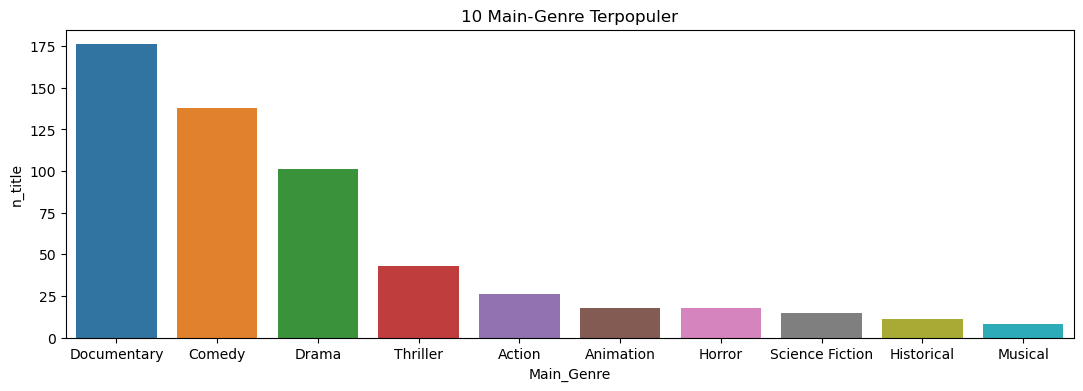

In [241]:
plt.figure(figsize= (13, 4))

plt.title('10 Main-Genre Terpopuler')
sns.barplot(data= top10_popular.sort_values('n_title', ascending= False).head(10), x= 'Main_Genre', y= 'n_title')

plt.show()

Setelah divisualisasikan kita dapat melihat bahwa 3 genre yang paling populer adalah documentary, comedy, dan drama. Selisih antara urutan ke 3 (drama) dan<br>
ke 4 (thriller) cukup jauh.<br><br>
Selanjutnya mari kita lihat performa ke-3 genre tersebut berdasarkan kolom 'IMDB Score'. Karena persebaran data pada kolom 'IMDB Score' tidak normal, kita akan menggunakan median. <br>
Kita akan menggunakan nilai median dari keseluruhan konten untuk menilai performa dari genre tersebut, dimana median dari keseluruhan konten adalah 6.35

In [242]:
median_overall = np.median(df['IMDB Score'])
median_overall

6.35

In [243]:
top10_popular.sort_values('median_score', ascending= False).head(10)

,Main_Genre,n_title,median_score
8,Documentary,176,7.10
2,Animation,18,6.80
9,Drama,101,6.40
12,Historical,11,6.20
0,Action,26,6.05
14,Musical,8,5.80
6,Comedy,138,5.80
17,Science Fiction,15,5.80
19,Thriller,43,5.70
13,Horror,18,5.35


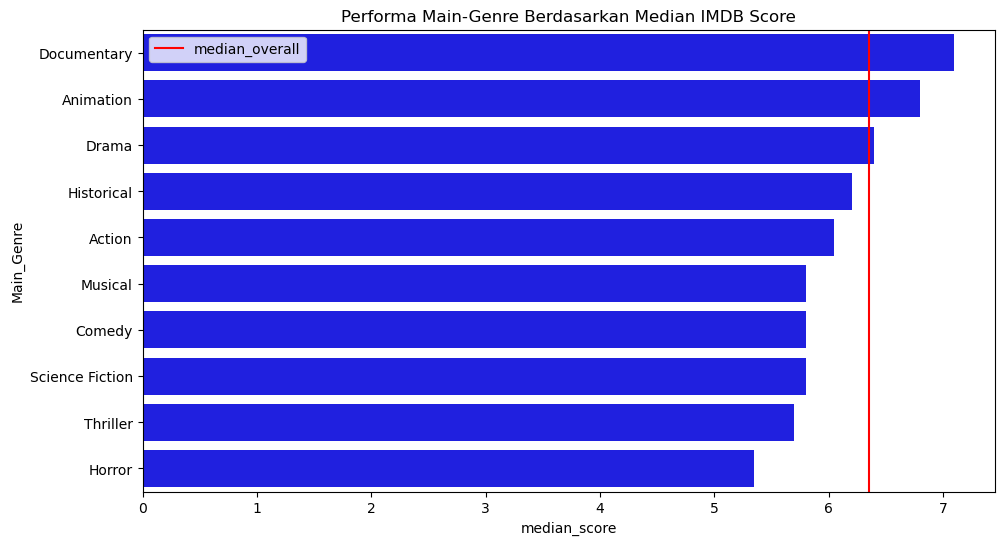

In [244]:
plt.figure(figsize= (11, 6))

plt.title('Performa Main-Genre Berdasarkan Median IMDB Score')
sns.barplot(
    data= top10_popular.sort_values('median_score', ascending= False).head(10),
    x= 'median_score', 
    y= 'Main_Genre',
    color= 'blue'
)
plt.axvline(median_overall, color='red', label= 'median_overall')
plt.legend()

plt.show()

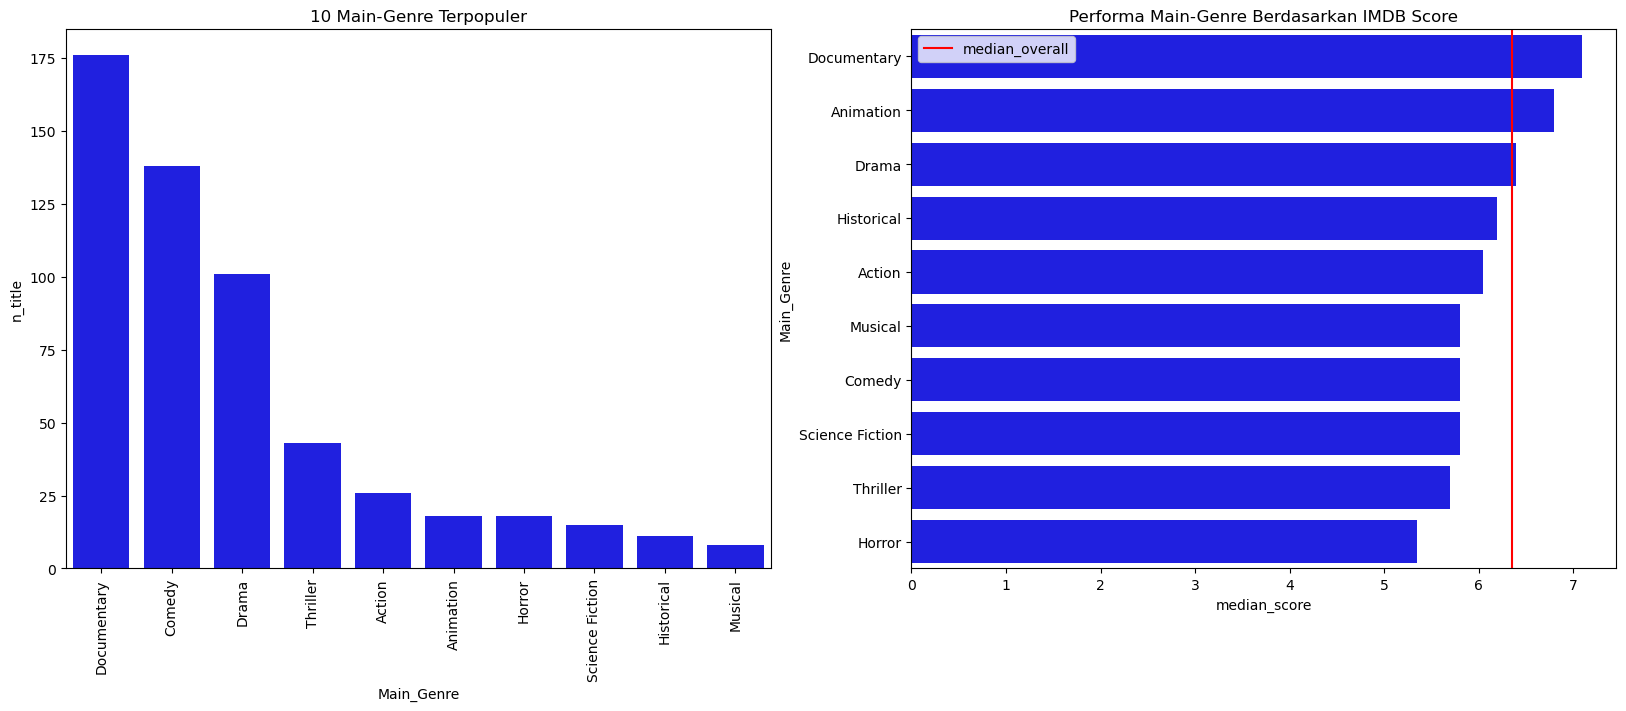

In [284]:
median_overall = np.median(df['IMDB Score'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

sns.barplot(
    ax= axes[0],
    data= top10_popular.sort_values('n_title', ascending= False).head(10), 
    x= 'Main_Genre', 
    y= 'n_title',
    color= 'blue'
)

sns.barplot(
    ax= axes[1],
    data= top10_popular.sort_values('median_score', ascending= False).head(10),
    x= 'median_score', 
    y= 'Main_Genre',
    color= 'blue'
)

axes[0].set_title('10 Main-Genre Terpopuler')
axes[1].set_title('Performa Main-Genre Berdasarkan IMDB Score')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

plt.axvline(median_overall, color='red', label= 'median_overall')
plt.legend()

plt.show()

Dari visualisasi, dapat dilihat bahwa genre yang paling diminati oleh konsumen berdasarkan popularitas dan skor adalah genre documentary. Meskipun genre drama dan komedi tidak berada di peringkat kedua dan ketiga berdasarkan nilai 'median_score', perbedaan jumlah kontennya sangat signifikan. Nilai median dari genre documentary dan drama lebih tinggi dari nilai median secara keseluruhan, namun median dari genre comedy nilainya lebih rendah dari nilai median secara keseluruhan.

Kita sekarang sudah memiliki 2 genre yang memiliki potensi, yaitu genre documentary dan drama. Genre comedy harus kita analis lebih jauh, apakah jika dikombinasikan dengen genre lain performanya akan meningkat.

In [246]:
# Top 3 berdasarkan genre utama (main genre)
top3_mg = df[df['Main_Genre'].str.contains('Documentary|Drama|Comedy', case= False)]
top3_mg.head(1)

,Title,Main_Genre,Genre,Premiere,Runtime,IMDB Score,Language
0,#REALITYHIGH,Comedy,Comedy,2017-09-08,99,5.2,English


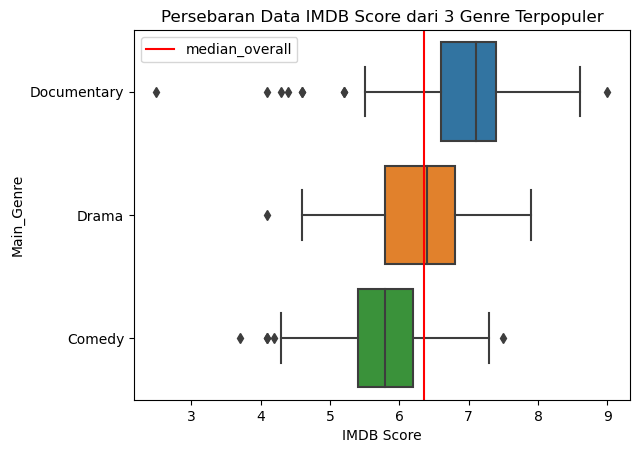

In [247]:
sns.boxplot(data= top3_mg.sort_values('IMDB Score', ascending= False), x= 'IMDB Score', y= 'Main_Genre')

plt.title('Persebaran Data IMDB Score dari 3 Genre Terpopuler')
plt.axvline(median_overall, color='red', label= 'median_overall')
plt.legend()

plt.show()

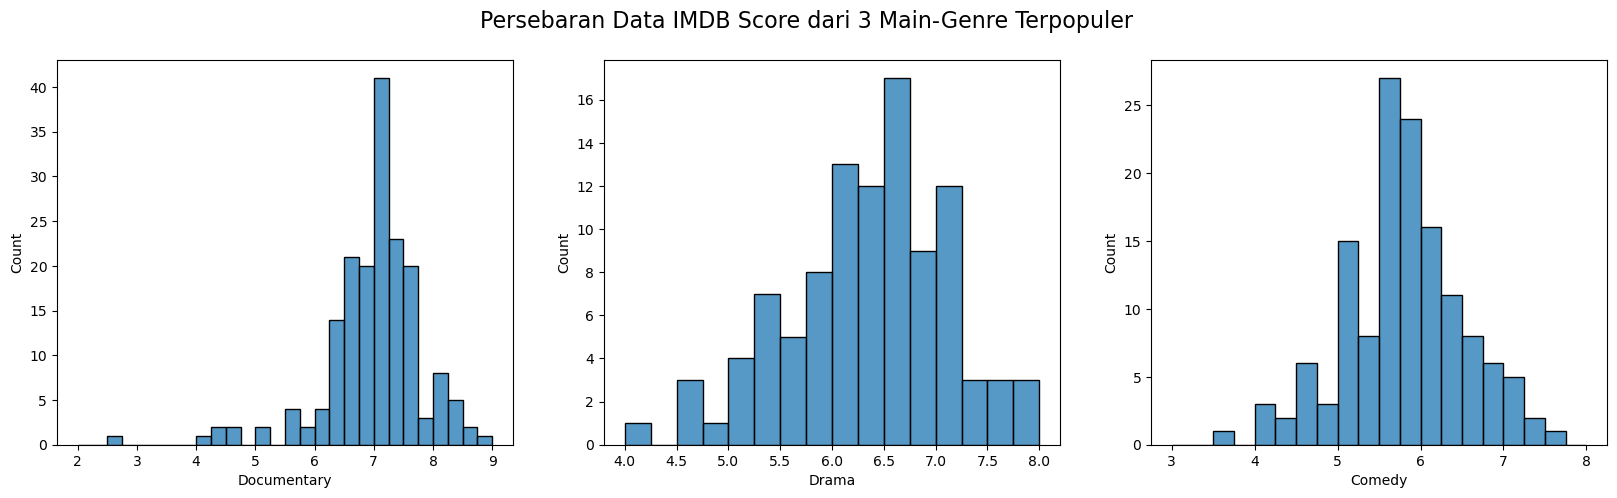

In [287]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# Create the subplots
sns.histplot(ax=axes[0], data=df.loc[df['Main_Genre'] == 'Documentary', 'IMDB Score'], binrange= (2, 9), binwidth= 0.25)
sns.histplot(ax=axes[1], data=df.loc[df['Main_Genre'] == 'Drama', 'IMDB Score'], binrange= (4, 8), binwidth= 0.25)
sns.histplot(ax=axes[2], data=df.loc[df['Main_Genre'] == 'Comedy', 'IMDB Score'], binrange= (3, 8), binwidth= 0.25)

# Set main title for the subplots
fig.suptitle('Persebaran Data IMDB Score dari 3 Main-Genre Terpopuler', fontsize=16)

# Add genre labels at the bottom of each plot
axes[0].set_xlabel('Documentary')
axes[1].set_xlabel('Drama')
axes[2].set_xlabel('Comedy')

plt.show()

Hasil visualisasi menggunakan boxplot dan histogram juga menunjukan bahwa persebaran data pada genre comedy mayoritasnya ada pada range score 5.5 - 6, berbeda dengan genre documentary dan drama yang mayoritas datanya ada pada range di atas median overall.

Notes : median overall = 6.35

***
## Mencari Kombinasi Genre Berdasarkan 3 Main_Genre Terpopuler

In [249]:
# Top 3 berdasarkan genre 
top3_g = df[df['Main_Genre'].str.contains('Documentary|Drama|Comedy', case= False)]
top3_g.head()

,Title,Main_Genre,Genre,Premiere,Runtime,IMDB Score,Language
0,#REALITYHIGH,Comedy,Comedy,2017-09-08,99,5.2,English
1,13th,Documentary,Documentary,2016-10-07,100,8.2,English
2,13th: A Conversation with Oprah Winfrey & Ava DuVernay,Documentary,Documentary,2017-01-26,36,7.1,English
3,15 August,Comedy,Comedy / Drama,2019-03-29,124,5.8,Marathi
5,22 July,Drama,Drama,2018-10-10,144,6.8,English


In [250]:
# Group by Top 3 Genre
gb_top3_g = top3_g.groupby('Genre').agg({'Title': 'count', 'IMDB Score': 'median'})\
    .rename(columns={'Title': 'n_title', 'IMDB Score': 'median_score'}).reset_index()

gb_top3_g = gb_top3_g.sort_values('n_title', ascending= False)
gb_top3_g

,Genre,n_title,median_score
7,Documentary,168,7.00
0,Comedy,110,5.70
9,Drama,98,6.35
1,Comedy / Drama,20,5.85
8,Documentary / Musical,8,7.60
4,Comedy / Horror,3,5.80
5,Comedy / Musical,2,6.20
2,Comedy / Fantasy,1,5.40
3,Comedy / Holiday,1,6.10
6,Comedy / Mystery,1,6.00


In [251]:
gb_top3_g['Genre'].head(10).unique()

array(['Documentary', 'Comedy', 'Drama', 'Comedy / Drama',
       'Documentary / Musical', 'Comedy / Horror', 'Comedy / Musical',
       'Comedy / Fantasy', 'Comedy / Holiday', 'Comedy / Mystery'],
      dtype=object)

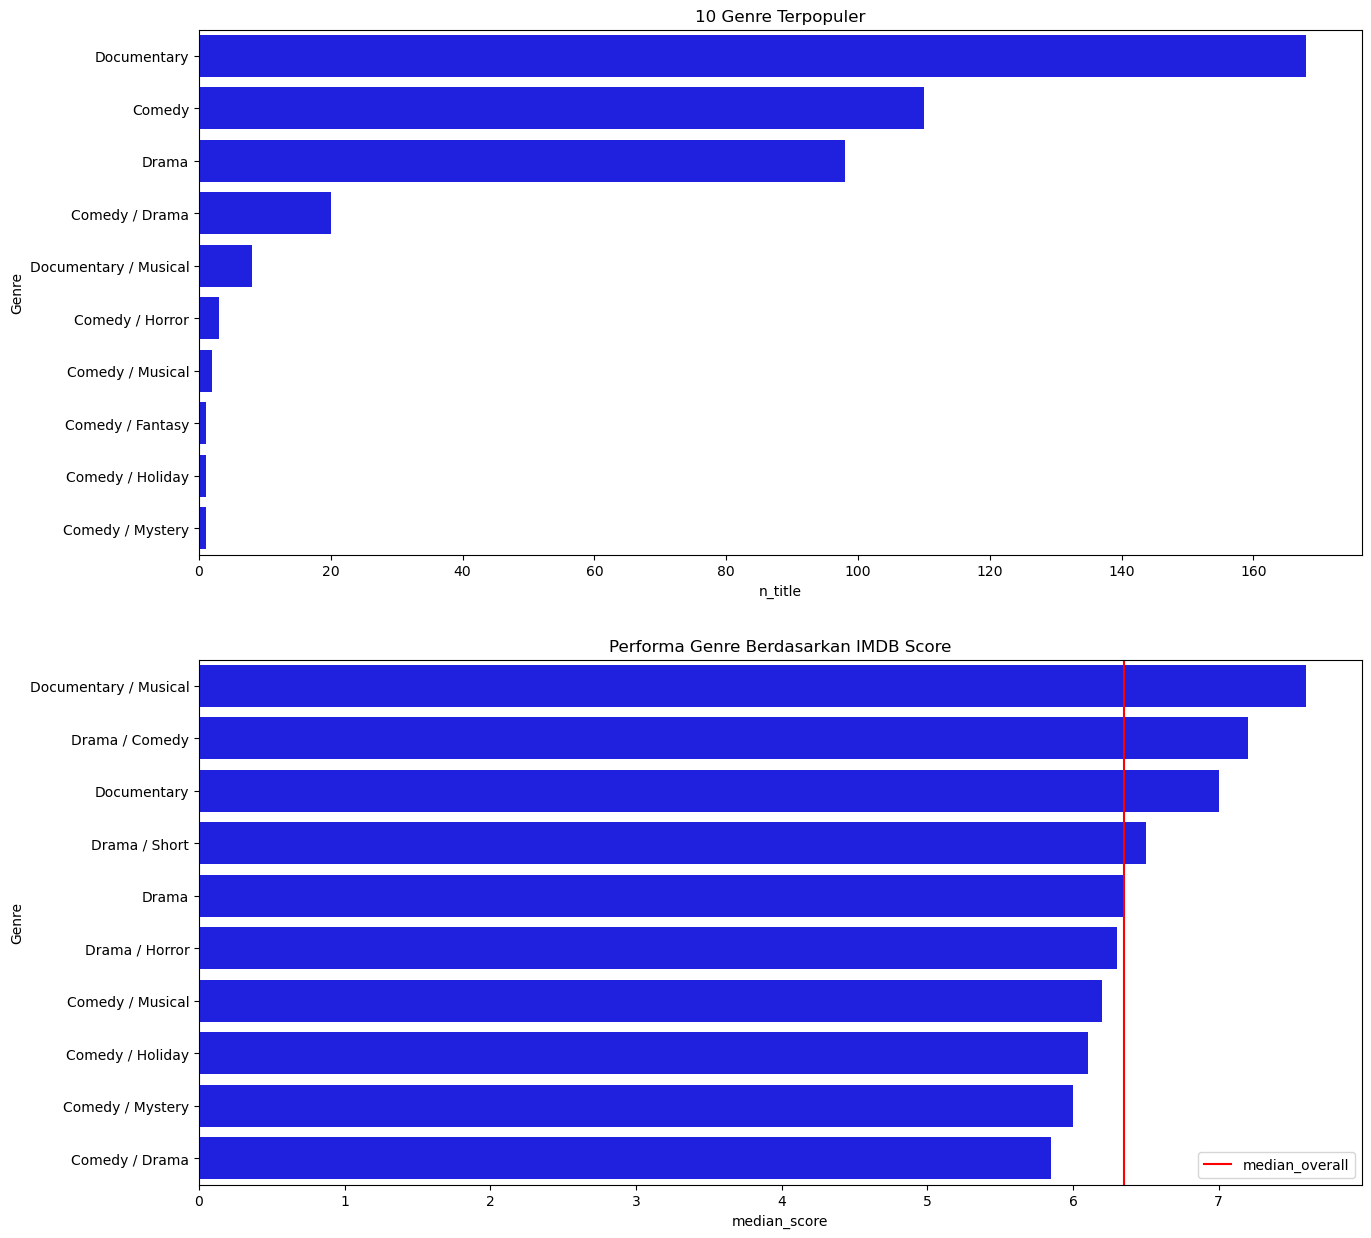

In [252]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

sns.barplot(
    ax= axes[0],
    data= gb_top3_g.head(10), 
    x= 'n_title', 
    y= 'Genre',
    color= 'blue'
)

sns.barplot(
    ax= axes[1],
    data= gb_top3_g.sort_values('median_score', ascending= False).head(10),
    x= 'median_score', 
    y= 'Genre',
    color= 'blue'
)

axes[0].set_title('10 Genre Terpopuler')
axes[1].set_title('Performa Genre Berdasarkan IMDB Score')

plt.axvline(median_overall, color='red', label= 'median_overall')
plt.legend()

plt.show()

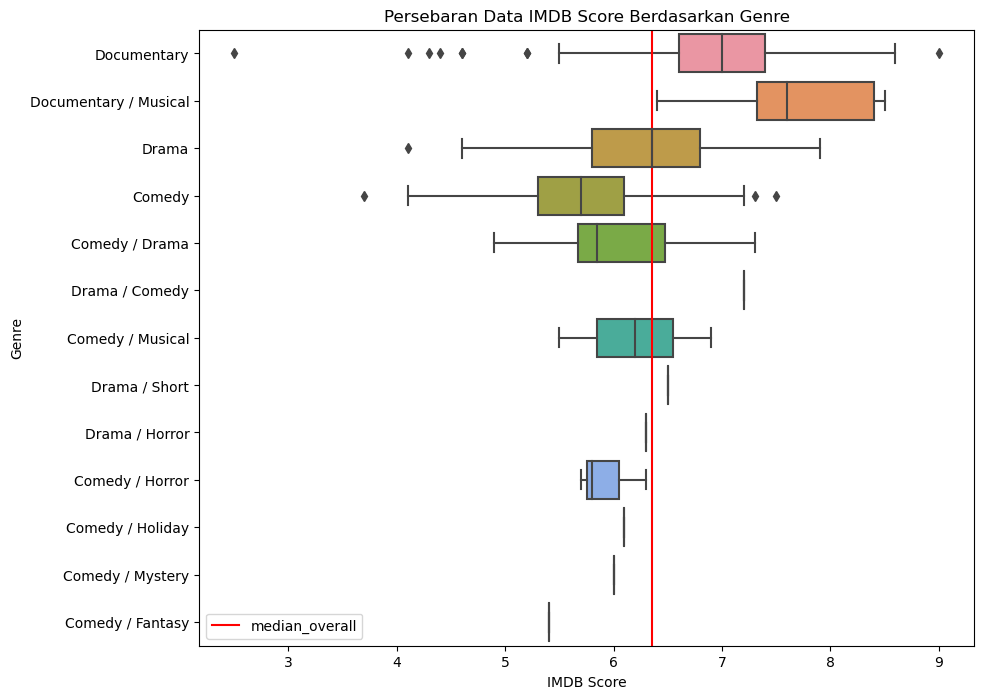

In [253]:
plt.figure(figsize=(10, 8))

plt.title('Persebaran Data IMDB Score Berdasarkan Genre')
sns.boxplot(data= top3_g.sort_values('IMDB Score', ascending=False), x='IMDB Score', y='Genre')

plt.axvline(median_overall, color='red', label= 'median_overall')
plt.legend()

plt.show()


In [254]:
df_comedy =  df[df['Main_Genre'].str.contains('Comedy')]
df_comedy.head()

,Title,Main_Genre,Genre,Premiere,Runtime,IMDB Score,Language
0,#REALITYHIGH,Comedy,Comedy,2017-09-08,99,5.2,English
3,15 August,Comedy,Comedy / Drama,2019-03-29,124,5.8,Marathi
6,5 Star Christmas,Comedy,Comedy,2018-12-07,95,4.6,Italian
11,A Babysitter's Guide to Monster Hunting,Comedy,Comedy / Fantasy,2020-10-15,98,5.4,English
12,A California Christmas,Comedy,Comedy,2020-12-14,107,5.8,English


In [255]:
print(f'''
Proporsi genre komedi di atas overall median: {np.round(len(df_comedy[df_comedy['IMDB Score'] >= median_overall]) / len(df_comedy) * 100, 2)}%
''')



Proporsi genre komedi di atas overall median: 18.84%



- Documentary bisa dikombinasikan dengan musikal untuk mendapat nilai median_score lebih tinggi, namun documentary tetap memiliki potensial yang lebih besar jika dilihat dengan membandingkan nilai maksimal dari kedua genre (dilihat melalui upper whisker dari boxplot) 
- Kita tidak bisa menentukan kombinasi untuk genre drama karena data yang terlalu sedikit, dimana jumlah konten yang memiliki kombinasi genre drama hanya 1 konten
- Genre komedi tetap tidak melewati nilai median_overall meski sudah dikombinasikan dengan genre lain, namun jika genre comedy dijadikan genre kedua lalu dikombinasikan dengan genre drama nilai median_score-nya akan meningkat, namun perlu digaris bawahi jumlah konten pada genre Drama / Comedy hanya 1 konten
- Jika dilihat secara proporsi jumlah konten komedi yang performanya di atas nilai median overall (6.35) hanya sebesar 18.84%, jadi kita tidak akan memasukan genre comedy sebagai genre yang direkomendasikan 

***
## Tren Perilisan Konten

Sekarang kita akan menganalisa berdasarkan kolom 'Premiere', yang kita cari adalah pola berulang berdasarkan banyaknya konten yang dirilis tiap bulan.

In [256]:
df_time = df.set_index('Premiere').copy()
df_time.head()

,Title,Main_Genre,Genre,Runtime,IMDB Score,Language
Premiere,,,,,,
2017-09-08,#REALITYHIGH,Comedy,Comedy,99,5.2,English
2016-10-07,13th,Documentary,Documentary,100,8.2,English
2017-01-26,13th: A Conversation with Oprah Winfrey & Ava DuVernay,Documentary,Documentary,36,7.1,English
2019-03-29,15 August,Comedy,Comedy / Drama,124,5.8,Marathi
2017-10-20,1922,Horror,Horror / Drama,102,6.3,English


In [257]:
df_month =  df_time.resample('M').count()['Title'].copy()
df_month.index = df_month.index.strftime('%B-%Y')

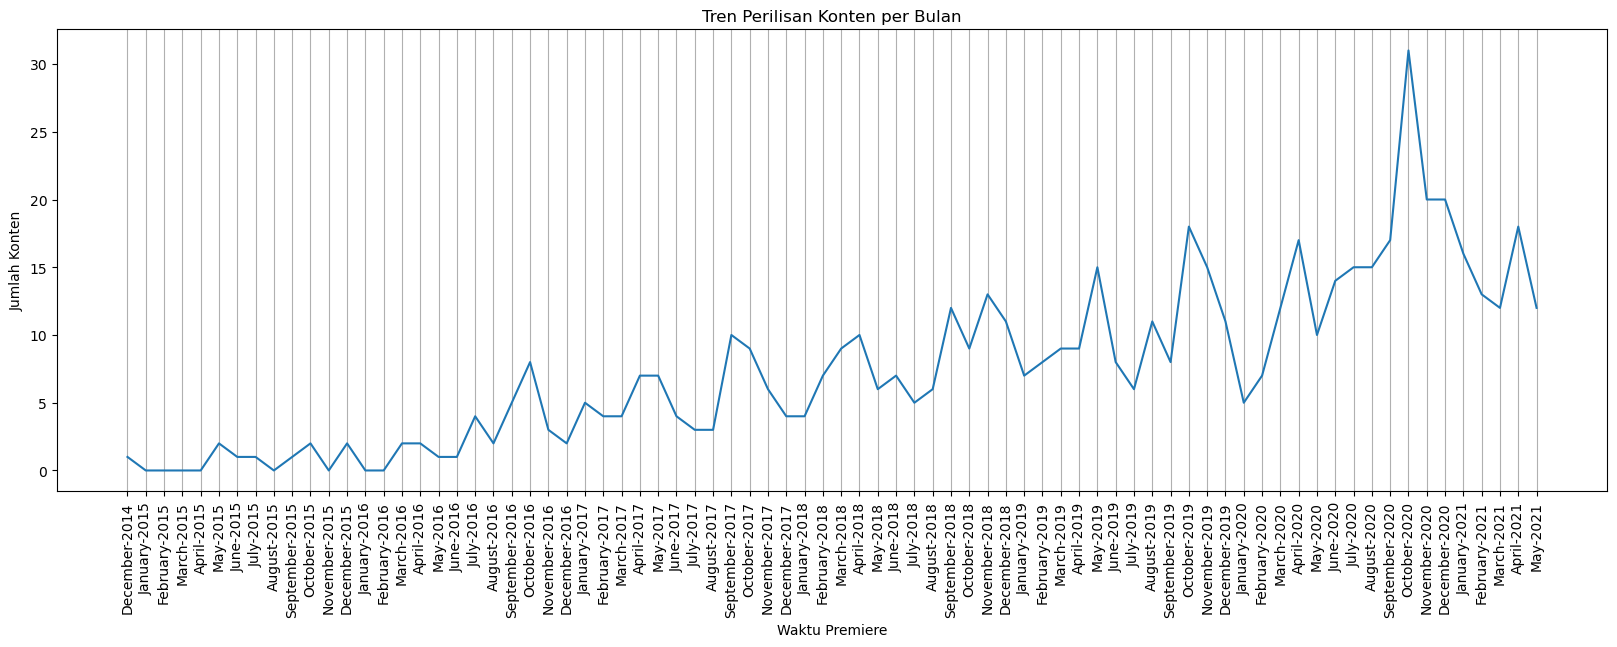

In [258]:
plt.figure(figsize= (20, 6))
plt.title('Tren Perilisan Konten per Bulan')

sns.lineplot(data= df_month)

plt.xlabel('Waktu Premiere')
plt.ylabel('Jumlah Konten')
plt.xticks(rotation= 90)

plt.grid(axis= 'x')

plt.show()

- Secara garis besar jumlah rilis konten meningkat setiap tahunnya 
- Terjadi pola periodik dimana biasanya terjadi peningkatan jumlah konten yang signifikan pada bulan september atau oktober yang kemudian diikuti dengan penurunan sampai bulan desember atau januari

***
## Tren Rilis Berdasar Main-Genre

In [259]:
# Tren berdasarkan kolom 'Premiere' untuk genre 'Documentary'
df_p_doc_tren =  df_time[df_time['Main_Genre'] == 'Documentary'].resample('M')[['Title']].count().copy()
df_p_doc_tren.index = df_p_doc_tren.index.strftime('%B-%Y')

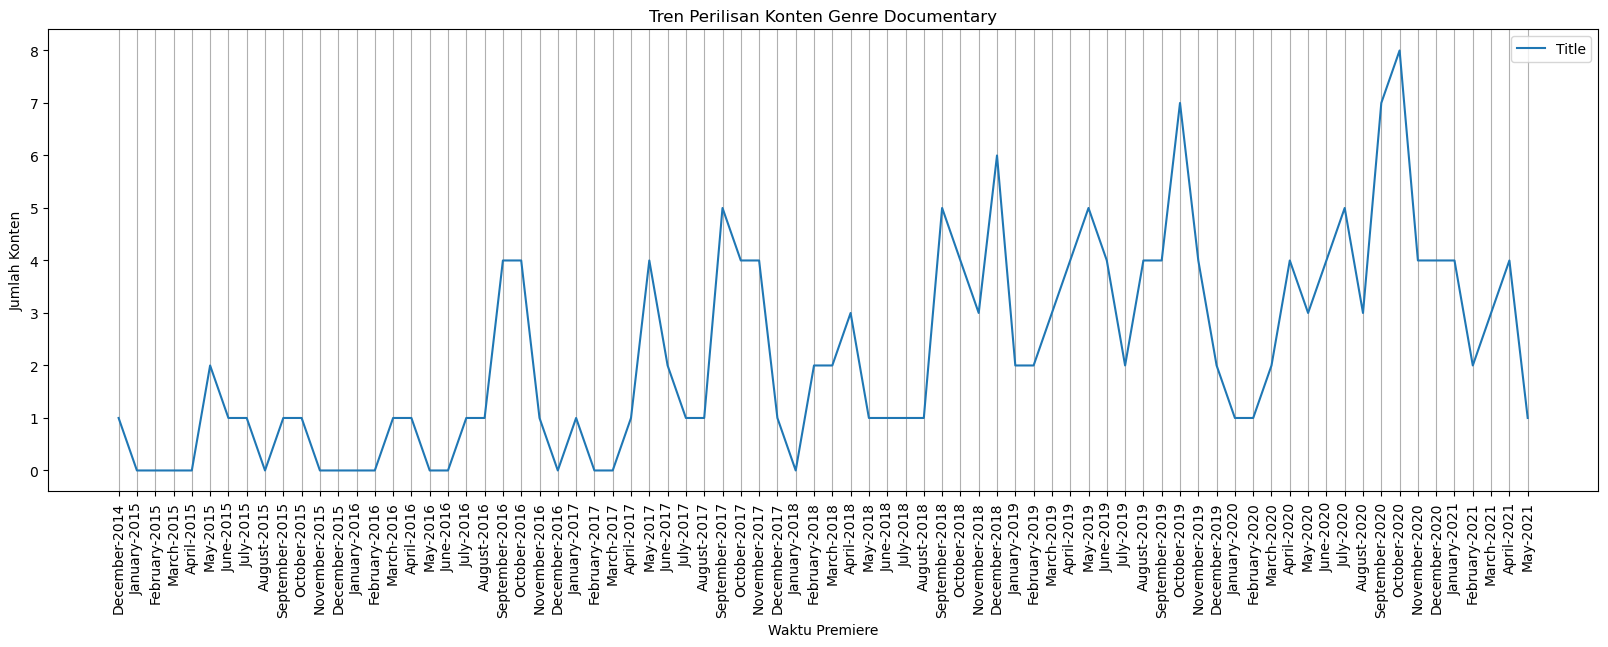

In [260]:
plt.figure(figsize= (20, 6))

plt.title('Tren Perilisan Konten Main-Genre Documentary')
sns.lineplot(data= df_p_doc_tren)

plt.xlabel('Waktu Premiere')
plt.ylabel('Jumlah Konten')
plt.xticks(rotation= 90)

plt.grid(axis= 'x')


plt.show()

Tren perilisan konten pada genre documentary polanya mirip dengan tren keseluruhan dimana pada bulan september atau oktober terjadi kenaikan jumlah konten yang signifikan

In [261]:
df_p_dra_tren =  df_time[df_time['Main_Genre'] == 'Drama'].resample('M').count()['Title'].copy()
df_p_dra_tren.index = df_p_dra_tren.index.strftime('%B-%Y')

In [262]:
df_p_dra_bar = df_p_dra_tren.reset_index().copy()
df_p_dra_bar.head()

,Premiere,Title
0,August-2016,1
1,September-2016,0
2,October-2016,1
3,November-2016,0
4,December-2016,0


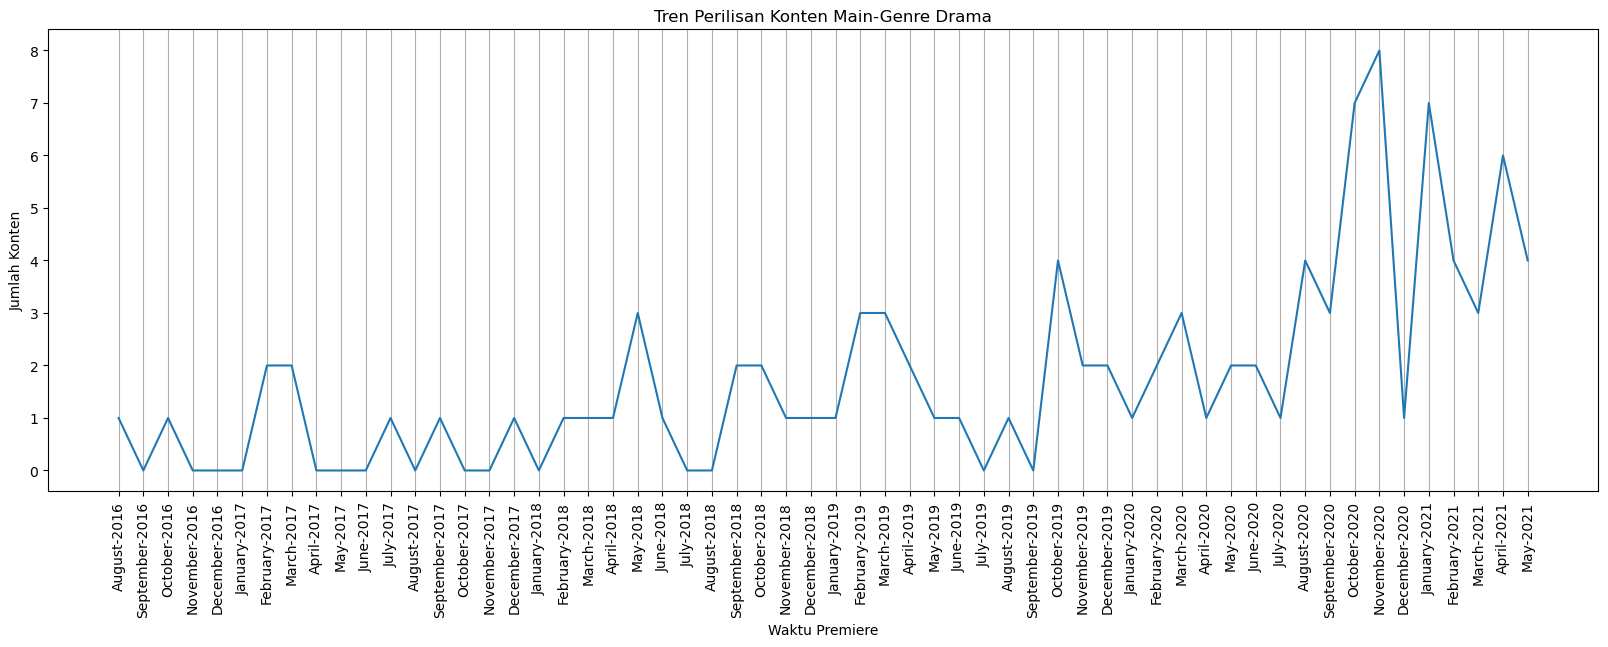

In [285]:
plt.figure(figsize= (20, 6))

plt.title('Tren Perilisan Konten Main-Genre Drama')
sns.lineplot(data= df_p_dra_tren)

plt.xlabel('Waktu Premiere')
plt.ylabel('Jumlah Konten')
plt.xticks(rotation= 90)

plt.grid(axis= 'x')


plt.show()

Pola Tren untuk genre drama sedikit berbeda. Lonjakan jumlah konten tidak selalu terjadi pada bulan september. Pada genre drama lonjakan kenaikan rilis konten kadang terjadi pada bulan Februari atau Maret

Kesimpulan :
- Secara garis besar tren pertumbuhan konten digital baik secara keseluruhan ataupun top 3 genre mengalami kenaikan seiring berjalannya waktu.<br>
- Jika dilihat secara keseluruhan perilisan konten membentuk pola periodik dimana biasanya terjadi lonjakan yang signifikan pada bulan september yang kemudian diikuti dengan penurunan sampai bulan desember atau januari
- Jika dilihat per genre waktu lonjakan kenaikan perilisan konten berbeda-beda, yaitu sebagai berikut:
    - Documentary : September / Oktober
    - Drama : Februari / Maret
- Kita bisa menentukan waktu premiere dengan cara memilih tanggal saat sebelum terjadi lonjakan yang perilisan konten. Hal ini kita lakukan untuk mengurangi kompetisi dengan production house yang lain

***
## Pertumbuhan Short Film

Di sini kita akan memfilter kolom 'Runtime' dan melakukan analisa terhadap film dengan durasi 40 menit, karena berdasarkan wikipedia short film adalah film/konten yang durasinya kurang dar 40 menit.<br>
Nanti kita akan melihat genre apa saja yang layak dipertimbangkan dan apakah waktu perilisan short konten membentuk pola periodik yang nantinya bisa kita gunakan untuk menentukan jadwal rilis konten.

Link wikipeda: https://en.wikipedia.org/wiki/Short_film

In [264]:
df_short = df[df['Runtime'] <= 40]
df_short.head()

,Title,Main_Genre,Genre,Premiere,Runtime,IMDB Score,Language
2,13th: A Conversation with Oprah Winfrey & Ava DuVernay,Documentary,Documentary,2017-01-26,36,7.1,English
10,A 3 Minute Hug,Documentary,Documentary,2019-10-28,28,6.5,English/Spanish
19,A Love Song for Latasha,Documentary,Documentary,2020-09-21,19,6.8,English
21,A Tale of Two Kitchens,Documentary,Documentary,2019-05-22,30,6.3,English/Spanish
25,After Maria,Documentary,Documentary,2019-05-24,37,4.6,English/Spanish


In [265]:
df_short_gb = df_short.groupby('Main_Genre').agg({'Title': 'count', 'IMDB Score': 'median'}) \
                  .rename(columns={'Title': 'n_title', 'IMDB Score': 'median_score'}) \
                  .reset_index()
df_short_gb = df_short_gb.sort_values('n_title', ascending=False)
df_short_gb

,Main_Genre,n_title,median_score
3,Documentary,37,6.8
0,Animation,5,7.1
2,Comedy,2,6.4
1,Anime,1,4.7
4,Drama,1,6.5
5,Musical,1,7.7


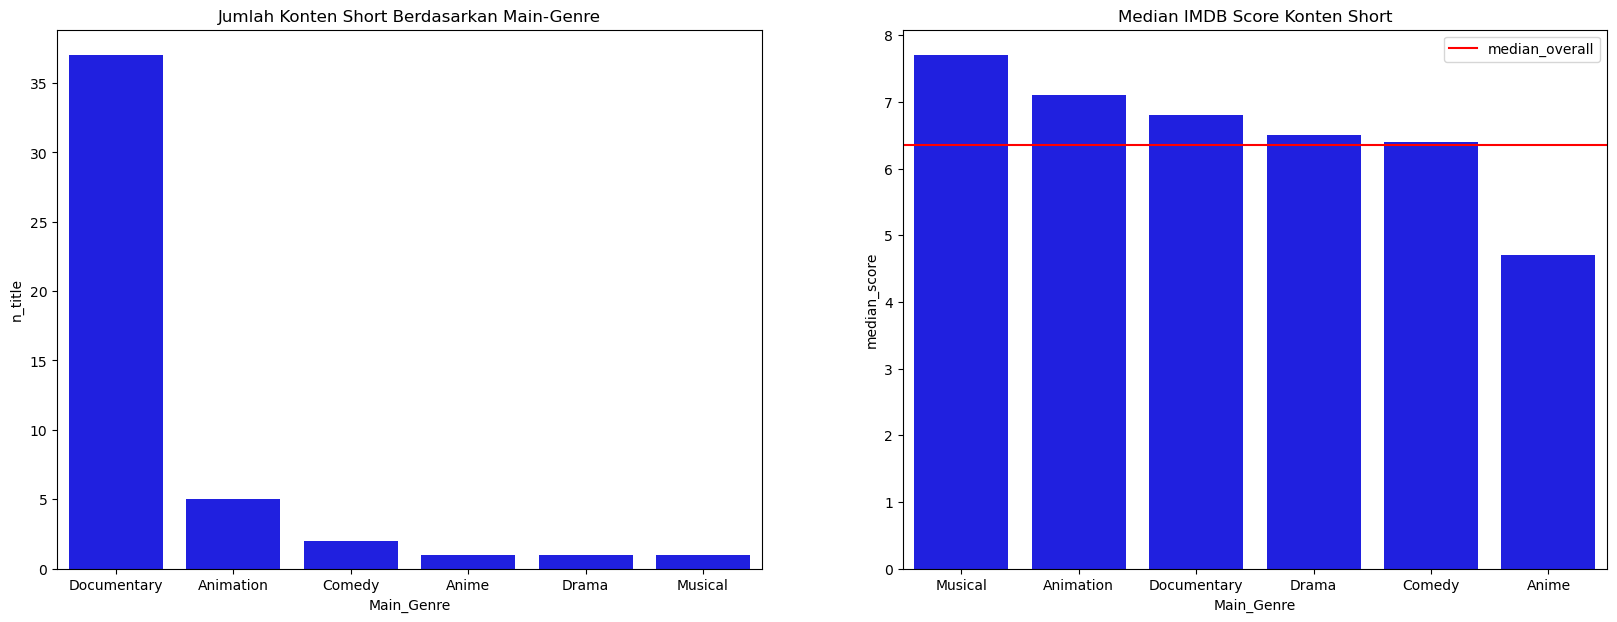

In [266]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

sns.barplot(
    ax= axes[0],
    data= df_short_gb, 
    x= 'Main_Genre', 
    y= 'n_title',
    color= 'blue'
)

sns.barplot(
    ax= axes[1],
    data= df_short_gb.sort_values('median_score', ascending= False).reset_index(),
    x= 'Main_Genre', 
    y= 'median_score',
    color= 'blue'
)
plt.axhline(median_overall, color='red', label= 'median_overall')
plt.legend()

axes[0].set_title('Jumlah Konten Short Berdasarkan Main-Genre')
axes[1].set_title('Median IMDB Score Konten Short')

plt.show()

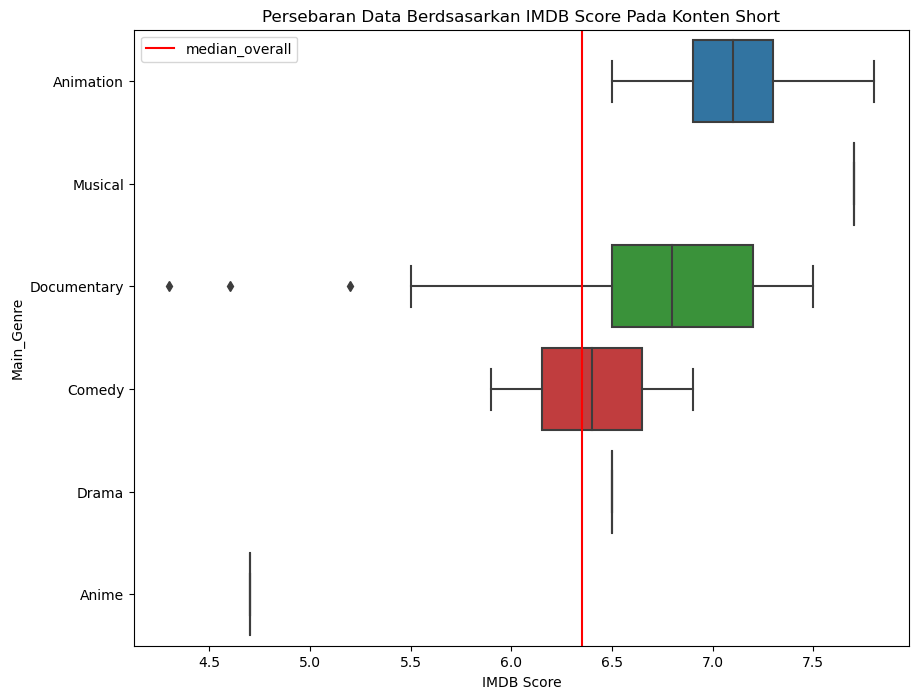

In [267]:
plt.figure(figsize=(10, 8))

plt.title('Persebaran Data Berdsasarkan IMDB Score Pada Konten Short')

sns.boxplot(data= df_short.sort_values('IMDB Score', ascending=False), x='IMDB Score', y='Main_Genre')

plt.axvline(median_overall, color='red', label= 'median_overall', )
plt.legend()

plt.show()


3 genre short konten yang paling populer adalah documentary dan animation. Jika dilihat berdasarkan median IMDB score, kedua genre ini juga memiliki nilai di atas median IMDB Score secara keseluruhan.

In [268]:
df_time_short = df_short.set_index('Premiere').copy()
df_time_short.head()

,Title,Main_Genre,Genre,Runtime,IMDB Score,Language
Premiere,,,,,,
2017-01-26,13th: A Conversation with Oprah Winfrey & Ava DuVernay,Documentary,Documentary,36,7.1,English
2019-10-28,A 3 Minute Hug,Documentary,Documentary,28,6.5,English/Spanish
2020-09-21,A Love Song for Latasha,Documentary,Documentary,19,6.8,English
2019-05-22,A Tale of Two Kitchens,Documentary,Documentary,30,6.3,English/Spanish
2019-05-24,After Maria,Documentary,Documentary,37,4.6,English/Spanish


In [269]:
df_month_short =  df_time_short.resample('M').count()[['Title']].copy()
df_month_short.index = df_month_short.index.strftime('%B-%Y')

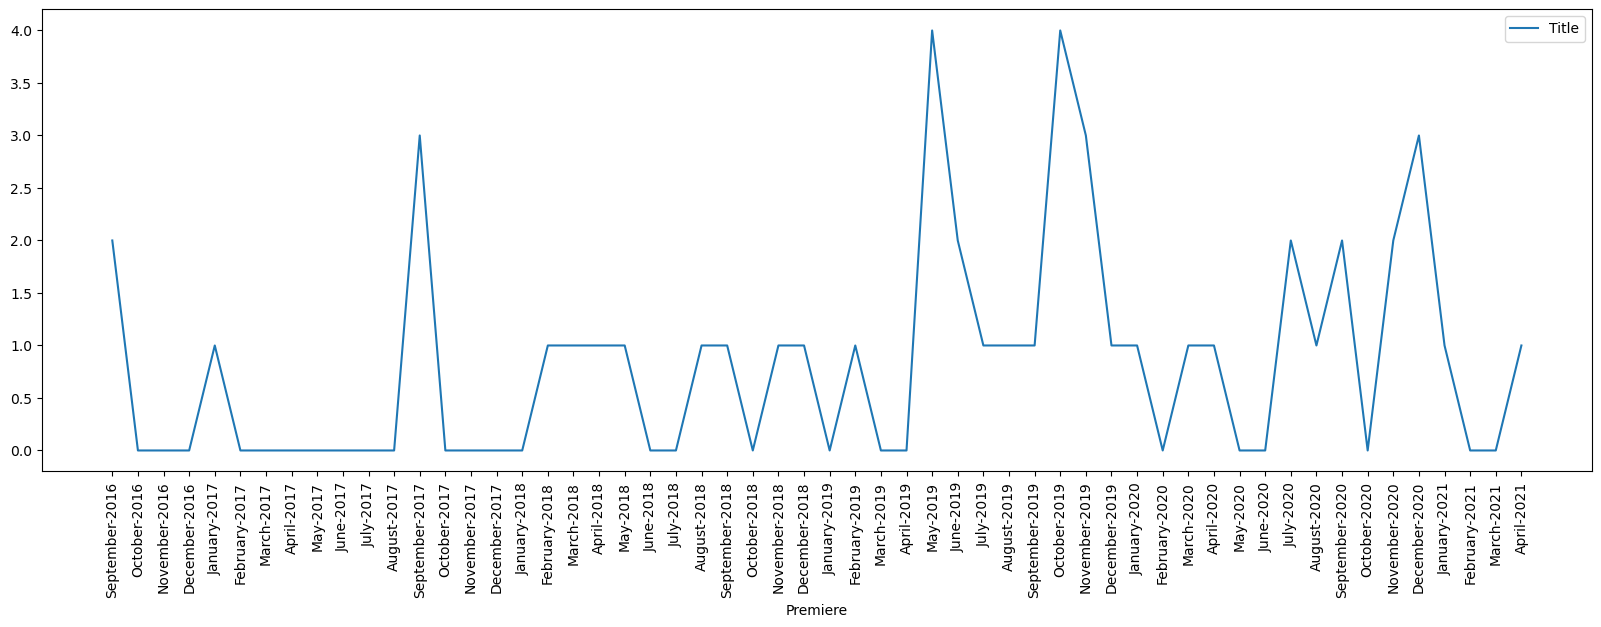

In [270]:
plt.figure(figsize= (20, 6))

sns.lineplot(data= df_month_short)
plt.xticks(rotation= 90)

plt.show()

In [271]:
Proporsi_short = round(((len(df_time_short) / len(df)) * 100), 2)

print(f'''
Proporsi konten short adalah {Proporsi_short}% dari keseluruhan konten
''')


Proporsi konten short adalah 8.05% dari keseluruhan konten



Kita tidak bisa mengambil kesimpulan dalam konteks waktu perilisan konten, karena hasil visualisasi menggunakan lineplot tidak membentuk pola apapun. Hal ini dapat disebabkan karena jumlah konten yang sangat sedikit, yaitu hanya sebesar 8.05% jika dibandingkan dengan jumlah konten secara keseluruhan.
Kita memang bisa mengambil kesimpulan dalam konteks popularitas dan performa, namun karena data konten short sangat sedikit terlebih lagi banyak genre yang hanya memiliki 1 konten, untuk saat ini kita tidak bisa merekomendasikan konten short.

***
## Berdasarkan Language

Dari data understanding kita mengetahui bahwa bahasa yang paling banyak digunakan adalah bahasa inggris, di sini kita akan menganalisa apakah ada bahasa lain yang layak dipertimbangkan untuk menjadi tambahan untuk konten yang akan diproduksi.

In [272]:
df.head()

,Title,Main_Genre,Genre,Premiere,Runtime,IMDB Score,Language
0,#REALITYHIGH,Comedy,Comedy,2017-09-08,99,5.2,English
1,13th,Documentary,Documentary,2016-10-07,100,8.2,English
2,13th: A Conversation with Oprah Winfrey & Ava DuVernay,Documentary,Documentary,2017-01-26,36,7.1,English
3,15 August,Comedy,Comedy / Drama,2019-03-29,124,5.8,Marathi
4,1922,Horror,Horror / Drama,2017-10-20,102,6.3,English


In [273]:
df_language = df.groupby('Language')[['Language']].count()
df_language = df_language.rename(columns= {'Language': 'n_konten'}).sort_values('n_konten', ascending= False).reset_index()
df_language.head(10)

,Language,n_konten
0,English,401
1,Hindi,33
2,Spanish,31
3,French,20
4,Italian,14
5,Portuguese,12
6,Indonesian,9
7,Korean,6
8,Japanese,6
9,German,5


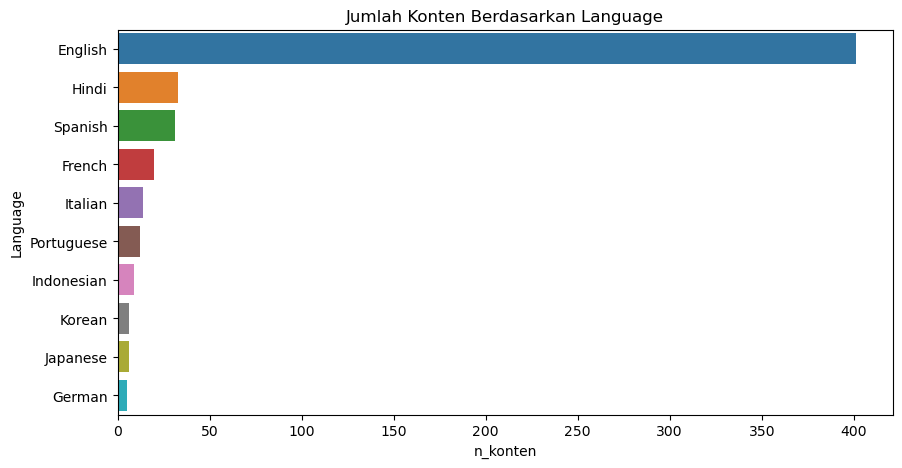

In [286]:
plt.figure(figsize= (10, 5))

plt.title('Jumlah Konten Berdasarkan Language')
sns.barplot(data= df_language.head(10), x= 'n_konten', y= 'Language')

plt.show()

Mayoritas konten yang tersedia didominasi oleh bahasa Inggris. Namun, bahasa Hindi, Spanish, dan French menarik untuk dianalisa lebih lanjut, karena  secara visual ketiga bahasa ini terlihat memiliki jumlah konten cukup banyak jika dibandingkan dengan bahasa lain yang bukan bahasa inggris.

Mari kita cek proporsinya jika dibandingkan dengan bahasa lain selain bahasa inggris.

In [275]:
# pd.set_option('display.max_rows', None)

df_non_english = df[df['Language'].str.contains('Hindi|Spanish|French')].sort_values('IMDB Score', ascending= False)
df_non_english = df_non_english.groupby('Language').agg({'Title': 'count', 'IMDB Score': 'median'}).reset_index()\
    .sort_values('Title', ascending= False).rename(columns= {'Title': 'n_konten', 'IMDB Score': 'median_score'})

df_non_english

,Language,n_konten,median_score
3,Hindi,33,6.1
5,Spanish,31,6.5
2,French,20,6.0
1,English/Spanish,5,6.4
0,English/Hindi,2,7.3
4,Khmer/English/French,1,7.2
6,Spanish/Basque,1,5.6
7,Spanish/Catalan,1,6.4
8,Spanish/English,1,7.3


In [278]:
proporsi = []
for i in range(len(df_non_english)):
    result = (df_non_english.iloc[i, 1] / len(df[~(df['Language'] == 'English')])) * 100
    proporsi.append(result)

In [279]:
df_non_english['proporsi (%)'] = np.round(proporsi, 2)
df_non_english.head()

,Language,n_konten,median_score,proporsi (%)
3,Hindi,33,6.1,18.03
5,Spanish,31,6.5,16.94
2,French,20,6.0,10.93
1,English/Spanish,5,6.4,2.73
0,English/Hindi,2,7.3,1.09


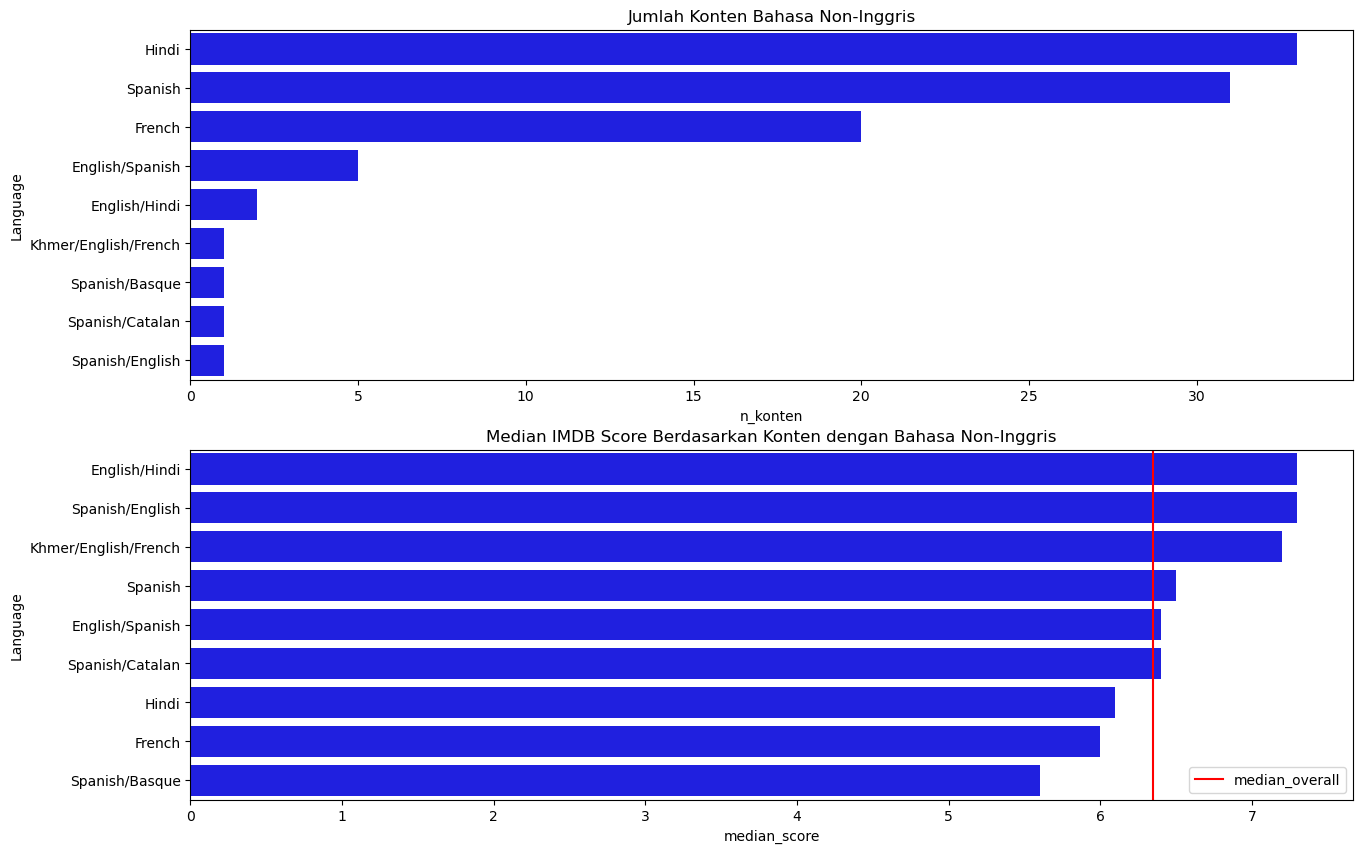

In [280]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.barplot(
    ax= axes[0],
    data= df_non_english.head(10), 
    x= 'n_konten',
    y= 'Language',
    color= 'blue'
)

sns.barplot(
    ax= axes[1],
    data= df_non_english.head(10).sort_values('median_score', ascending= False),
    x= 'median_score',
    y= 'Language',
    color= 'blue'
)
plt.axvline(median_overall, color='red', label= 'median_overall')
plt.legend()

axes[0].set_title('Jumlah Konten Bahasa Non-Inggris')
axes[1].set_title('Median IMDB Score Berdasarkan Konten dengan Bahasa Non-Inggris')

plt.show()

Dari tabel dan visualisasi kita bisa melihat bahwa bahasa Hindi dan Spanish bisa menjadi bahan pertimbangan. Karena proporsi kedua bahasa ini cukup besar jika dibandingkan dengan bahasa non-inggris, yaitu 18.03% untuk bahasa Hindi dan 16.94% untuk bahasa spanish. Jika dilihat dari segi performa bahasa spanish memiliki nilai median di atas median overall, sedangkan bahasa Hindi tidak. Namun jika bahasa hindi dikombinasikan dengan bahasa inggris nilai median score-nya akan melewati nilai median overall.

In [282]:
language_genre = df[df['Language'].str.contains('Hindi|Spanish|French')].groupby(['Language', 'Genre']).count()[['Title']]
language_genre = language_genre.sort_values('Title', ascending= False)\
    .rename(columns= {'Title': 'n_title'}).reset_index(level= 'Genre')
language_genre = language_genre[language_genre['Genre'].str.contains('Drama|Documentary')]
language_genre

,Genre,n_title
Language,,
Hindi,Drama,14
Spanish,Drama,9
Spanish,Documentary,9
French,Documentary,6
English/Spanish,Documentary,5
French,Drama,4
English/Hindi,Documentary,2
Hindi,Comedy / Drama,2
Spanish,Comedy / Drama,2


Dari tabel terlihat bahwa konten dengan bahasa spanish terdiri dari 9 konten dengan genre documentary dan 9 untuk drama, sedangkan untuk konten yang memiliki bahasa hindi dan english terdapat 2 konten documentary. Konten berbahasa hindi didominasi genre drama

***
# Kesimpulan dan Rekomendasi

Dari analisa yang sudah kita lakukan, kita bisa menarik beberapa kesimpulan :
- Dataset yang kita miliki secara proporsi hanya 20% dari total konten netflix original sesungguhnya
- Genre utama yang paling populer adalah genre documentary, comedy, dan drama
- Genre utama dengan performa di atas nilai median_overall adalah genre documentary dan drama, sedangkan genre comedy memiliki performa di bawah median_overall
- Genre documentary jika dikombinasikan dengan genre musical memiliki nilai median score yang lebih tinggi. Namun jika dilihat per konten, genre yang hanya documentary memiliki nilai maksimum yang lebih besar
- Secara garis besar tren pertumbuhan konten digital baik secara keseluruhan ataupun genre terpopuler mengalami kenaikan seiring berjalannya waktu
- Waktu perilisan konten membentuk pola periodik dimana biasanya terjadi lonjakan yang signifikan pada bulan september atau Oktober yang kemudian diikuti penurunan sampai bulan desember atau januari, jika dilihat per genre utama, waktu lonjakan kenaikan jumlah perilisan konten adalah sebagai berikut:
    * Documentary : September / Oktober
    * Drama : Februari / Maret<br>
Waktu rilis yang tepat adalah sebelum terjadi lonjakan kenaikan konten, hal ini dilakukan untuk mengurangi persaingan dengan production house lain
- 3 genre short konten yang paling populer adalah documentary, animation, dan comedy, dimana genre yang paling populer adalah documentary dan genre dengan performa median score terbaik adalah genre animation. Jika dilihat berdasarkan median IMDB score, ketiga genre ini juga memiliki nilai di atas median IMDB Score secara keseluruhan, namun kita tidak dapat mendapatkan insight untuk waktu perilisan konten, hal ini disebabkan karena data konten short sangat sedikit terlebih lagi banyak genre yang hanya memiliki 1 konten, untuk saat ini kita tidak bisa merekomendasikan konten short.
- Mayoritas konten yang tersedia didominasi oleh bahasa Inggris. Bahasa Hindi dan Spanish bisa menjadi bahan pertimbangan, karena proporsi kedua bahasa ini cukup besar jika dibandingkan dengan bahasa non-inggris, yaitu 18.03% untuk bahasa Hindi dan 16.94% untuk bahasa spanish. Jika dilihat dari segi performa bahasa spanish memiliki nilai median di atas median overall, sedangkan bahasa Hindi tidak. Namun jika bahasa hindi dikombinasikan dengan bahasa inggris nilai median score-nya akan melewati nilai median overall.
- Konten dengan bahasa spanish terdiri dari 9 konten dengan genre documentary dan 9 untuk drama, sedangkan untuk konten yang memiliki bahasa english dan hindi terdapat 2 konten documentary. Konten yang berbahasa hindi didominasi genre drama

## Rekomendasi 

Sekarang kita akan menjabarkan detail konten yang direkomendasikan berdasarkan hasil analisa yang kita buat. Dari hasil analisa kita bisa membuat 3 rekomendasi, dimana rekomendasi 1 adalah konten dengan performa dan popularitas yang paling tinggi

### Rekomendasi 1

- Genre utama : Documentary
- Kombinasi Genre : Musical (opsional)
- Waktu premiere : September / Oktober
- Prioritas bahasa : 
    1. English
    2. Spanish
    3. English / Hindi

Dasar Rekomendasi:<br>
Genre documentary adalah genre yang paling populer dan memiliki performa terbaik dilihat dari median score-nya. Genre ini dapat dikombinasikan dengan genre musikal untuk meningkatkan nilai median_score, tetapi perlu diingat bahwa jika melihat berdasarkan skor IMDB tertinggi per konten, genre documentary tanpa dikombinasikan adalah yang dominan.

Waktu yang tepat untuk merilis konten adalah bulan Agustus, sebelum terjadi lonjakan perilisan konten pada bulan September atau Oktober. Hal ini dilakukan untuk mengurangi persaingan dengan production house lain.

Kita juga dapat mempertimbangkan untuk menambahkan bahasa Spanish atau Hindi karena genre documentary dalam kedua bahasa ini memiliki performa dan jumlah konten yang cukup baik

### Rekomendasi 2

- Genre utama : Drama
- Kombinasi Genre : Comedy (opsional)
- Waktu premiere : Januari / Februari
- Prioritas bahasa : 
    1. English
    2. Spanish
    3. English / Hindi
    4. Hindi

Dasar Rekomendasi:
Genre Drama menempati ururtan ke 3 secara popularitas, namun performanya jika dilihat dari median score menempati urutan ke 2. Waktu yang tepat untuk merilis konten adalah bulan Januari atau bulan Februari bertepatan dengan hari kasih sayang atau biasa disebut dengan valentine, Namun perlu diingat jika berniat untuk merilis pada bulan februari persaingan pasti lebih tinggi jika dibandingkan dengan bulan Januari, karena secara historis pada bulan februari sering terjadi lonjakan perilisan konten dengan genre drama. Hal ini bisa ditanggulangi dengan perilisan teaser atau trailer sebelum bulan februari dimana persaingan masih rendah.

Kita juga dapat mempertimbangkan untuk menambahkan bahasa Hindi sebagai prioritas 1 atau Spanish sebagai prioritasa 2 karena bahasa Hindi lebih umum digunakan dalam genre drama dibandingkan dengan bahasa spanish 

**Notes** :<br>
Kita tidak menggunakan genre terpopuler ke 2 yaitu comedy karena performa dari comedy berdasarkan median score tidak melewati median overall dari keseluruhan data.